# medsrtqc

[![Check](https://github.com/ArgoCanada/medsrtqc/actions/workflows/check.yaml/badge.svg)](https://github.com/ArgoCanada/medsrtqc/actions/workflows/check.yaml)
[![Codecov test coverage](https://codecov.io/gh/ArgoCanada/medsrtqc/branch/master/graph/badge.svg)](https://codecov.io/gh/ArgoCanada/medsrtqc?branch=master)

A possible container for MEDS real-time quality control code.

## Installation

You can install the `medsrtqc` package using `pip`.

``` bash
pip install git+https://github.com/ArgoCanada/medsrtqc.git
```

## Examples

QC code in `medsrtqc` is built on the `Trace` and `Profile` classes. A `Profile` is roughly what you would get from a single-cycle Argo NetCDF file. The `Profile` can be subclassed to abstract away the storage details such that QC code can be tested on NetCDF files but run with an arbitrary storage backend. You can get started with the NetCDF backend in a few lines:

In [1]:
from medsrtqc.nc import read_nc_profile
url = 'https://data-argo.ifremer.fr/dac/coriolis/6904117/profiles/R6904117_085.nc'
profile = read_nc_profile(url)
profile['TEMP']

Trace(
    value=[13.3847, 12.9791, 12.3505, [194 values], 7.2176, 7.2166, 7.2168],
    qc=[b'1', b'1', b'1', [194 values], b'1', b'1', b'1'],
    adjusted=[masked, masked, masked, [194 values], masked, masked, masked],
    adjusted_error=[masked, masked, masked, [194 values], masked, masked, masked],
    pres=[5.27, 5.79, 6.48, [194 values], 201.5, 202.54, 203.5],
    mtime=[masked, masked, masked, [194 values], masked, masked, masked]
)

You can specify multiple files to combine e.g. a core and a BGC file that represent the same `Profile` but are split into two files for historical and/or logistical reasons.

In [2]:
import re
url_bgc = re.sub(r'/R', '/BR', url)
profile = read_nc_profile(url, url_bgc)
print(repr(profile['CHLA']))
print(repr(profile['TEMP']))

Trace(
    value=[1.5622, 1.533, 1.533, [1267 values], 0.3577, 0.365, 0.3504],
    qc=[b'2', b'2', b'2', [1267 values], b'2', b'2', b'2'],
    adjusted=[0.7811, 0.7665, 0.7665, [1267 values], 0.17885, 0.1825, 0.1752],
    adjusted_error=[masked, masked, masked, [1267 values], masked, masked, masked],
    pres=[0.3, 0.3, 0.3, [1267 values], 204.1, 204.0, 204.0],
    mtime=[0.007025253, 0.0069095124, 0.006793772, [1267 values], -0.052315023, -0.052430764, -0.052546505]
)
Trace(
    value=[13.3847, 12.9791, 12.3505, [194 values], 7.2176, 7.2166, 7.2168],
    qc=[b'1', b'1', b'1', [194 values], b'1', b'1', b'1'],
    adjusted=[masked, masked, masked, [194 values], masked, masked, masked],
    adjusted_error=[masked, masked, masked, [194 values], masked, masked, masked],
    pres=[5.27, 5.79, 6.48, [194 values], 201.5, 202.54, 203.5],
    mtime=[masked, masked, masked, [194 values], masked, masked, masked]
)


You can use the interactive plotter to quickly visualize all or part of a profile:

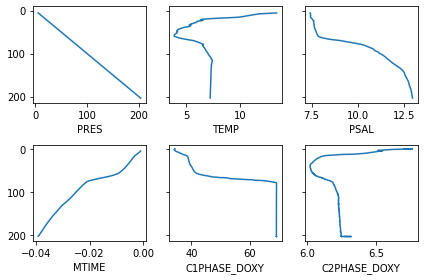

In [3]:
from medsrtqc.interactive import plot
fig, axs = plot(profile, vars=profile.keys()[:6])

You can use the `Trace` and `Profile` classes directly to generate unit test data with known statistical properties:

In [4]:
from medsrtqc.core import Trace, Profile
Trace([1, 2, 4], adjusted=[2, 3, 5], pres=[0, 1, 2])

Trace(
    value=[1.0, 2.0, 4.0],
    qc=[masked, masked, masked],
    adjusted=[2.0, 3.0, 5.0],
    adjusted_error=[masked, masked, masked],
    pres=[0.0, 1.0, 2.0],
    mtime=[masked, masked, masked]
)

## QC A VMS .DAT file

This doesn't quote work (it looks like the pressure QC flags aren't updating) but it's close!

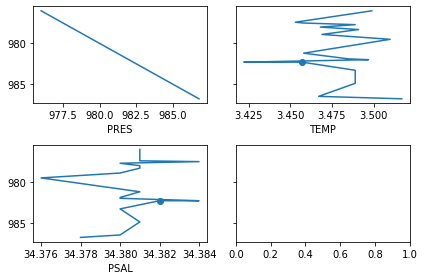

In [5]:
from medsrtqc.vms import read_vms_profiles, write_vms_profiles
from medsrtqc.resources import resource_path
from medsrtqc.qc.flag import Flag
from medsrtqc.qc.named_tests import PressureIncreasingTest
import matplotlib.pyplot as plt

# load file
profs = read_vms_profiles(resource_path('BINARY_VMS.DAT'))

# run test on a prof that will fail
test = PressureIncreasingTest()
prof = profs[0]
test.run(prof)  # False

# check result (should have one point marked as bad)
fig, axs = plot(prof, vars=('PRES', 'TEMP', 'PSAL'))
for i, var in enumerate(('PRES', 'TEMP', 'PSAL')):
    t = prof[var]
    bad = t.qc == Flag.BAD
    plt.subplot(2, 2, i + 1).scatter(t.value[bad], t.pres[bad])

# if you want to write changes to disk
# profs[0] = prof
# write_vms_profiles(profs, 'output_file.DAT')

## QC a NetCDF file

This should work but I haven't tested properly yet.

In [6]:
prof = read_nc_profile(resource_path('R6904117_085.nc'), mode='r+')
test = PressureIncreasingTest()
test.run(prof)
# prof.close() if you want to write changes to disk

True